In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from data_loader import get_train_loader, get_test_loader

from model import ResNet, EfficientNetwork
from functions import LabelSmoothingCrossEntropy
from utils import get_accuracy, train_stats, train_val_stats

import warnings
warnings.filterwarnings("ignore")


architecture = 'resnet'
num_classes = 42
batch_size = 32
num_epochs = 20
save_every = 1
print_every = 1000
log_file1 = 'training_log.txt'
log_file2 = 'training_val_log.txt'

In [2]:
train_loader, valid_loader = get_train_loader(
    csv_file='/workspace/dataset/train.csv', 
    root_dir='/workspace/dataset/train/train', 
    batch_size=batch_size, 
    augment=True, 
    random_seed=128, 
    valid_size=0.1, 
    shuffle=True,
    num_workers=4)

test_loader = get_test_loader(
    csv_file='/workspace/dataset/test.csv', 
    root_dir='/workspace/dataset/test/test', 
    batch_size=batch_size, 
    num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('GPU availability: {}'.format(device))

GPU availability: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


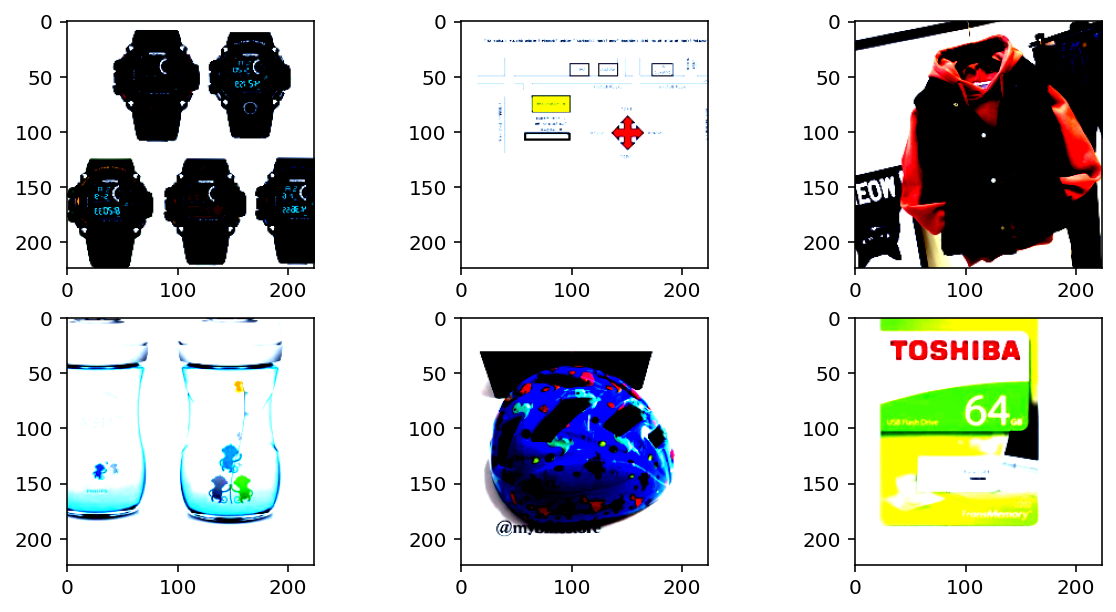

In [3]:
n_sample = 5
columns = 3
rows = 2

fig = plt.figure(figsize=(10, 5))
dataset = iter(train_loader)

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i+1)
    image = next(dataset)['image'][i]
    image = image.permute(1, 2, 0).data.numpy()
    ax.imshow(image)
        
plt.show()

## Define Model

In [3]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
    
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor  if use_gpu else torch.LongTensor
ByteTensor  = torch.cuda.ByteTensor  if use_gpu else torch.ByteTensor
Tensor      = FloatTensor

if architecture == 'resnet':
    model = ResNet(num_classes)
elif architecture == 'efficient_net':
    model = EfficientNetwork(num_classes)

if use_gpu: 
    model.to(device)

criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
# criterion = LabelSmoothingCrossEntropy(0.1).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_step = len(train_loader)
print('Number of training step: {}'.format(training_step))

sample_in = torch.Tensor(1, 3, 380, 380).cuda()
sample_out = model(sample_in)
assert(sample_out.shape == (1, num_classes))

Number of training step: 2965


In [4]:
def train_model(num_epochs, log_file1, log_file2):
    f1 = open(log_file1, 'w')
    f2 = open(log_file2, 'w')
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    
    for epoch in range(1, num_epochs + 1):
        running_accuracy, running_loss = 0, 0
        
        for batch_i, data in enumerate(train_loader, start=1):
            model.train()
            images, labels = data['image'].to(device), data['label'].to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            correct = get_accuracy(preds, labels).type(FloatTensor)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += torch.mean(correct).item()
            
            stats = train_stats(epoch, 
                                num_epochs, 
                                batch_i, 
                                training_step, 
                                loss.item(), 
                                torch.mean(correct).item())
            
            f1.write(stats + '\n')
            f1.flush()
            
            if (batch_i % print_every) == 0:
                val_loss = 0
                val_accuracy = 0
                model.eval()
                with torch.no_grad():
                    for _, data in enumerate(valid_loader):
                        images, labels = data['image'].to(device), data['label'].to(device)
                        preds = model(images)
                        loss = criterion(preds, labels)
                        val_loss += loss.item()
                        val_accuracy += torch.mean(get_accuracy(preds, labels).type(FloatTensor)).item()
                                
                    valid_loss.append(val_loss/len(valid_loader))
                    valid_acc.append(val_accuracy/len(valid_loader))
                    
                    train_loss.append(running_loss/print_every)
                    train_acc.append(running_accuracy/print_every)

                val_stats = train_val_stats(epoch,
                                        num_epochs,
                                        batch_i,
                                        training_step,
                                        train_loss[-1],
                                        train_acc[-1], 
                                        valid_acc[-1])
                
                f2.write(val_stats + '\n')
                f2.flush()
                print('\r', val_stats)
                
                running_loss, running_accuracy = 0, 0
                
        if epoch % save_every == 0:
            torch.save(model.state_dict(), 
                       os.path.join('./models', 'resnet-%d.pkl' % epoch))
        
    f1.close()
    f2.close()
    
    return train_loss, train_acc


In [6]:
loss, acc = train_model(num_epochs, log_file1, log_file2)

In [11]:
def test_model():
    model.eval()
    preds = []
    
    for i, data in enumerate(test_loader):
        images = data['image'].type(torch.FloatTensor)
        labels = data['label']
        
        outputs = model(images)
        
        outputs = F.log_softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, axis=1)
        
        for e in predicted.cpu().numpy():
            preds.append(e)
    
    return preds

In [12]:
model.load_state_dict(torch.load('/workspace/models/resnet-20.pkl'))

preds = test_model()
print(len(preds))

In [14]:
version = 1.5

df = pd.read_csv('/workspace/dataset/test.csv')
df['category'] = preds
df.to_csv('/workspace/results/test_result_{}.csv'.format(version), index=False)

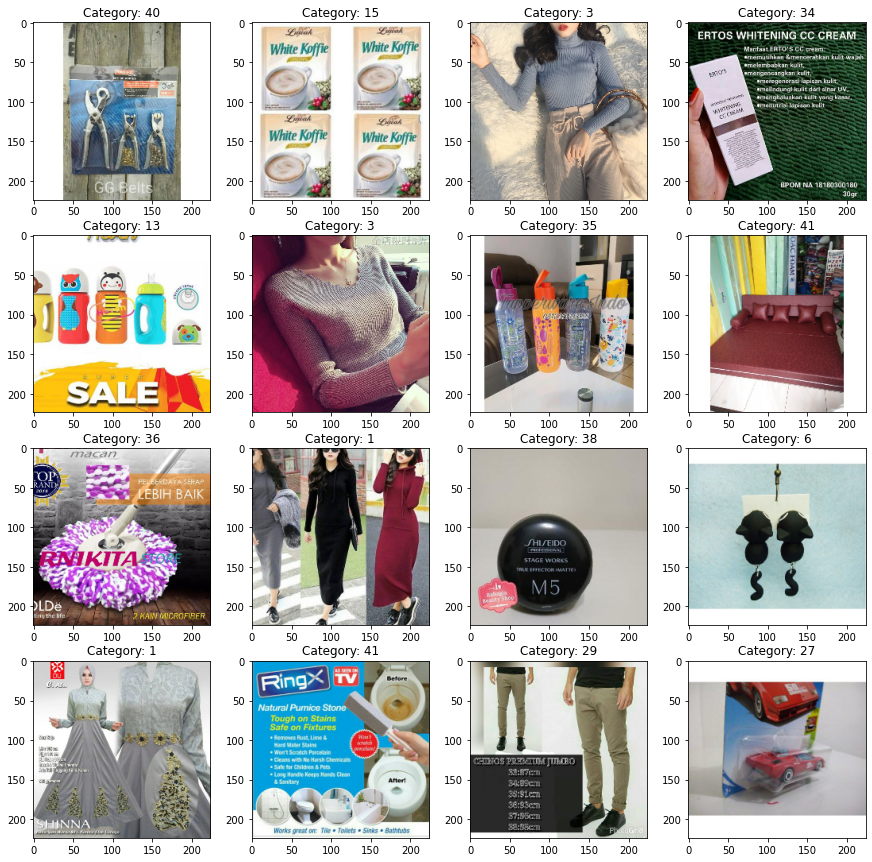

In [19]:
import cv2
import matplotlib.image as mpimg


test_df = df.sample(n=batch_size)
columns = 4
rows = 4
fig = plt.figure(figsize=(15, 15))

for i in range(columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    row = test_df.iloc[i]
    image_name = os.path.join('/workspace/dataset/test/test', row['filename'])
    image = mpimg.imread(image_name)
    image = cv2.resize(image, (224, 224))
    ax.imshow(image)
    ax.set_title('Category: {}'.format(row['prediction']))
plt.show()


In [7]:
torch.cuda.empty_cache()